# Texture analysis

In [1]:
# Nummerical library
import numpy as np

# System library e.g. for opening files in a library
import os

# Use %matplotlib notebook for nice looking figures
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook

import imageio
import scipy.ndimage as snd
from skimage import feature
from glob import glob

C:\Users\Sverrir\Anaconda3\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Load data

C:\Users\Sverrir\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


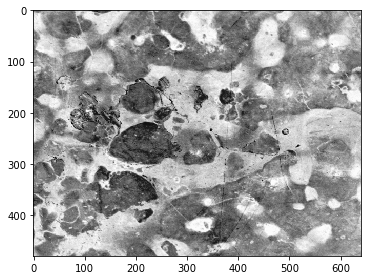

In [2]:
image = plt.imread('texture_data/T09_marble/T09_01.jpg').astype('float')

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.imshow(image, cmap='Greys')

fig.show()
fig.tight_layout()

## Reminders

Gaussian filters (1D), first and second order derivatives.

In [3]:
# t is the variance of the gaussian distribution 
# s is the size of the filter (how many times the standard deviation, between 3 and 5)

def gaussian(t=3, s=5):
    x = np.arange(-np.ceil(s*np.sqrt(t)), np.ceil((s*np.sqrt(t)))+1)
    filt = 1.0/np.sqrt(t*2.0*np.pi)*np.exp(-(x**2.0)/(2.0*t))
    return filt

def fst_deriv_gaussian(t=3, s=5):
    x = np.arange(-np.ceil(s*np.sqrt(t)), np.ceil((s*np.sqrt(t)))+1)
    filt = (-x/t)*gaussian(t, s=s)
    return filt

def scd_deriv_gaussian(t=3, s=5):
    x = np.arange(-np.ceil(s*np.sqrt(t)), np.ceil((s*np.sqrt(t)))+1)
    filt = ((x**2.0)/(t**2.0) - 1/t)*gaussian(t, s=s)
    return filt

In [4]:
gaussian()

array([3.15772229e-07, 5.36877205e-06, 6.54050331e-05, 5.70929583e-04,
       3.57099381e-03, 1.60040839e-02, 5.13934433e-02, 1.18255074e-01,
       1.94969656e-01, 2.30329433e-01, 1.94969656e-01, 1.18255074e-01,
       5.13934433e-02, 1.60040839e-02, 3.57099381e-03, 5.70929583e-04,
       6.54050331e-05, 5.36877205e-06, 3.15772229e-07])

Choose a scale. Remember that $r=\sqrt{2t}\Leftrightarrow t=r^2/2$.

In [5]:
radius = 5
t = radius**2/2
gauss_filter = gaussian(t)

In [6]:
def convolve(image, kernel): # convolve an image with a 1D kernel
    convolved_1D = snd.filters.convolve1d(image, kernel, axis=1)
    convolved_2D = snd.filters.convolve1d(convolved_1D, np.transpose(kernel), axis=0)
    return convolved_2D

$$L_{xx}=\frac{d^2}{dx^2}L=\frac{d^2}{dx^2}I*g(x,y)=\frac{d^2}{dx^2}I*g(x)*g(y)=g(y)*I*\frac{d^2g(x)}{dx^2}$$
This means $L_{xx}$ is calculated by colvoling the image with the 2nd derivative of the gaussian along the x-axis and a regular gaussian along the y-axis.

## Define ad-hoc filters

In [7]:
def gaussian_features(image, scale):

    t            = scale**2
    gauss        = gaussian(t)
    first_gauss  = fst_deriv_gaussian(t)
    second_gauss = scd_deriv_gaussian(t)

    # First Gaussian filter 
    s = convolve(image, gauss_filter)

    # Second Gaussian filter
    sx = snd.filters.convolve1d(image, first_gauss, axis=1)
    sx = snd.filters.convolve1d(sx, np.transpose(gauss), axis=0)

    # Third Gaussian filer
    sy = snd.filters.convolve1d(image, np.transpose(first_gauss), axis=0)
    sy = snd.filters.convolve1d(sy, gauss, axis=1)

    # Fourth Gaussian filter
    sxx = snd.filters.convolve1d(image, second_gauss, axis=1)
    sxx = snd.filters.convolve1d(sxx, np.transpose(gauss), axis=0)

    # Fifth Gaussian filer
    syy = snd.filters.convolve1d(image, np.transpose(second_gauss), axis=0)
    syy = snd.filters.convolve1d(syy, gauss, axis=1)

    # Sixth Gaussian filter
    sxy = snd.filters.convolve1d(image, first_gauss, axis=1)
    sxy = snd.filters.convolve1d(sxy, np.transpose(first_gauss), axis=0)
    
    return s,sx,sy,sxx,syy,sxy

In [8]:
# First for one specific scale
scale = 2
s,sx,sy,sxx,syy,sxy = gaussian_features(image, scale)

C:\Users\Sverrir\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


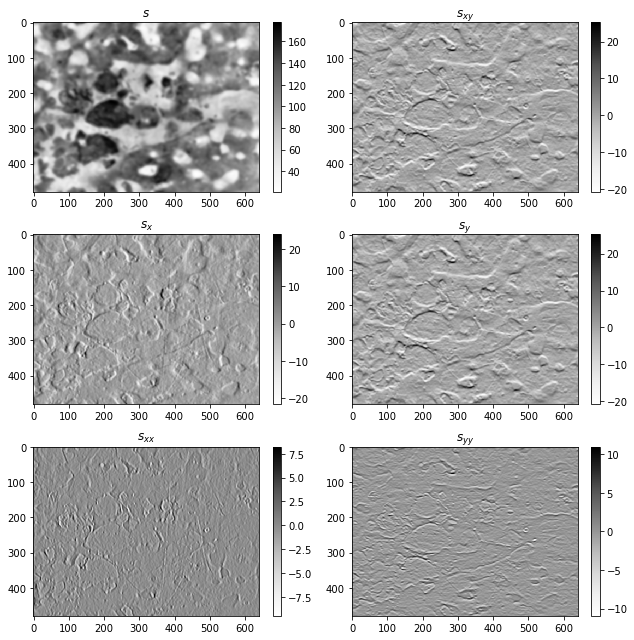

In [9]:
fig1, f1_axes = plt.subplots(ncols=2, nrows=3, constrained_layout=False, figsize=(9,9))

# first row
im1 = f1_axes[0,0].imshow(s, cmap='Greys') 
f1_axes[0,0].set_title('$s$')
fig1.colorbar(im1, ax=f1_axes[0,0], fraction=0.046)
im2 = f1_axes[0,1].imshow(sy, cmap='Greys')
f1_axes[0,1].set_title('$s_{xy}$')
fig1.colorbar(im2, ax=f1_axes[0,1], fraction=0.046)

# second row
im3 = f1_axes[1,0].imshow(sx, cmap='Greys')
f1_axes[1,0].set_title('$s_{x}$')
fig1.colorbar(im3, ax=f1_axes[1,0], fraction=0.046)
im4 = f1_axes[1,1].imshow(sy, cmap='Greys')
f1_axes[1,1].set_title('$s_{y}$')
fig1.colorbar(im4, ax=f1_axes[1,1], fraction=0.046)

# third row
im5 = f1_axes[2,0].imshow(sxx, cmap='Greys')
f1_axes[2,0].set_title('$s_{xx}$')
fig1.colorbar(im5, ax=f1_axes[2,0], fraction=0.046)
im6 = f1_axes[2,1].imshow(syy, cmap='Greys')
f1_axes[2,1].set_title('$s_{yy}$')
fig1.colorbar(im6, ax=f1_axes[2,1], fraction=0.046)

fig1.show()
fig1.tight_layout()


## BIF, Basic image features

In [10]:
def basic_image_features(image, scale, epsilon = 0.): 

    s,sx,sy,sxx,syy,sxy = gaussian_features(image, scale)
    
    flat    = epsilon*s
    slope   = 2*np.sqrt(sx**2+sy**2)
    saddle  = np.sqrt((sxx - syy)**2 + 4*sxy**2)
    white_blob = sx+sy
    dark_blob  = -(sx+sy)
    white_line = 2**(-1/2) * (saddle + white_blob)
    dark_line  = 2**(-1/2) * (saddle + dark_blob)
    
    return flat, slope, dark_blob, white_blob, dark_line, white_line, saddle

C:\Users\Sverrir\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


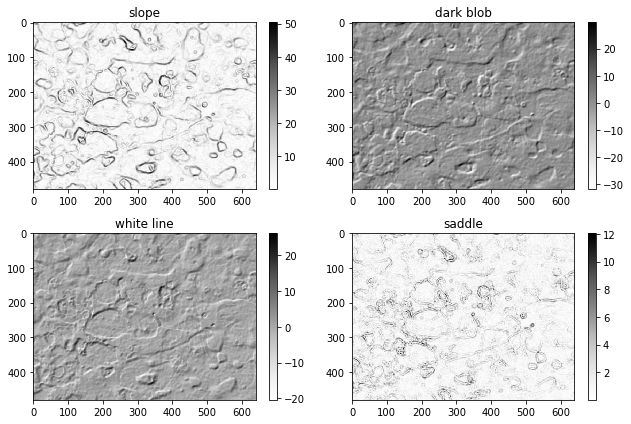

In [11]:
flat, slope, dark_blob, white_blob, dark_line, white_line, saddle = basic_image_features(image, scale, 0.)

fig1, f1_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=False, figsize=(9,6))

# first row
im1 = f1_axes[0,0].imshow(slope, cmap='Greys') 
f1_axes[0,0].set_title('slope')
fig1.colorbar(im1, ax=f1_axes[0,0], fraction=0.046)
im2 = f1_axes[0,1].imshow(dark_blob, cmap='Greys')
f1_axes[0,1].set_title('dark blob')
fig1.colorbar(im2, ax=f1_axes[0,1], fraction=0.046)

# second row
im3 = f1_axes[1,0].imshow(white_line, cmap='Greys')
f1_axes[1,0].set_title('white line')
fig1.colorbar(im3, ax=f1_axes[1,0], fraction=0.046)
im4 = f1_axes[1,1].imshow(saddle, cmap='Greys')
f1_axes[1,1].set_title('saddle')
fig1.colorbar(im4, ax=f1_axes[1,1], fraction=0.046)

fig1.show()
fig1.tight_layout()

In [12]:
def feature_classification_scale(image, scale, epsilon = 0.):

    flat, slope, dark_blob, white_blob, dark_line, white_line, saddle = basic_image_features(image, scale, epsilon)  

    # define a tensor with evrery BIF piled up
    BIF_image = np.stack((flat, slope, dark_blob, white_blob, dark_line, white_line, saddle), axis=2)
    BIF_image.shape
    
    L = np.argmax(BIF_image, axis=2) 
    
    return L

In [13]:
classification = feature_classification_scale(image, scale, epsilon = 0.)

C:\Users\Sverrir\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


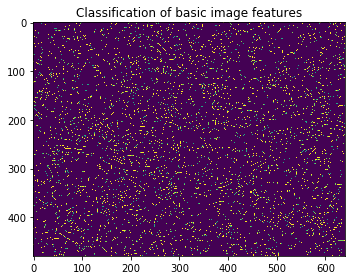

In [14]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

im1 = ax.imshow(classification)
ax.set_title('Classification of basic image features')

fig.show()
fig.tight_layout()

## Texture classification

In [15]:
def BIF_histogram(image, scale_list,epsilon=0.):

    L = np.zeros((image.shape[0], image.shape[1], len(scale_list)))

    for i in range(len(scale_list)):

        # classification of BIF for one scale
        L[:,:,i] = feature_classification_scale(image, scale_list[i], epsilon) 
        # L.shape

    # multiply by 6^i
    X = np.stack([6**i*L[:,:,i] for i in range(len(scale_list))], axis=2)

    # transform our classification 3d-array into a integer matrix of values [0,6^n-1]
    B = np.sum(X, axis=2, dtype=np.int)
    
    # store data into an histogram
    size_histo = round((6**(len(scale_list)+1)-1)/5) # maximum value of a point 6666... in base 6
    histo = np.zeros(size_histo)
    for i in range(size_histo):
        histo[i] = np.sum(B.flatten()==i)
    
    return B, histo

In [16]:
#import seaborn as sns
#import pandas.util.testing as tm
#sns.set()

scale_list = [1,2,4,8]
epsilon = 0. # important here

B, _ = BIF_histogram(image, scale_list, epsilon=0.)

C:\Users\Sverrir\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


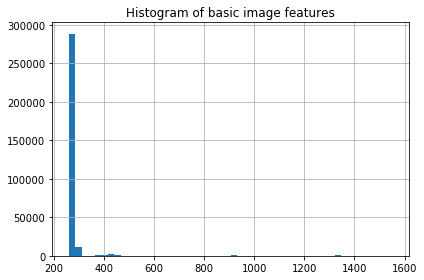

In [17]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

im1 = ax.hist(B.flatten(),bins=50)
ax.set_title('Histogram of basic image features')
ax.grid(True)

fig.show()
fig.tight_layout()

In [19]:
scale_list = [1,2,4,8]
epsilon = 0. # important here

size_histo = round((6**(len(scale_list)+1)-1)/5)
h_list = []

texture_file_names = glob('./texture_data/T*/*')
n_tex = len(texture_file_names)
for file_name in texture_file_names:
    image = plt.imread(file_name).astype('float')
    _, histo = BIF_histogram(image, scale_list, epsilon=0.)
    h_list.append(histo)

In [ ]:
collection_labels = [x.split('\\')[1] for x in texture_file_names]

In [ ]:
diff_matrix = [[np.sum(np.abs(i-j)) for i in h_list] for j in h_list] # evaluate the difference between the histogram 


In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

cax = ax.matshow(diff_matrix)
ax.set_yticks(np.arange(2,27.1,5))
ax.set_yticklabels(collection_labels[::5])
ax.set_xticks(np.arange(2,27.1,5))
ax.set_xticklabels(collection_labels[::5],rotation=-45)
ax.hlines(np.arange(-0.5,27,5),-0.5,29.5,color='red')
ax.vlines(np.arange(-0.5,27,5),-0.5,29.5,color='red')
fig.colorbar(cax)

fig.show()
fig.tight_layout()

#### Explain the pattern
Since each collection of textures has exactly 5 samples and the images were ordered such that each collection came sequentially we see this repeating pattern of slightly darker 5 by 5 rectangles along the diagonal of the matrix. This pattern has two notable deviations:
<ol>
<li>The 10 by 10 rectangle between granite and marble. This is because of the relative similarity of the two, so they could easily be confused with one another based on the features used</li>
    
<li>The 2 by 2 and 3 by 3 rectangle inside the 5 by 5 upholstry rectangle. If you open the upholstry files, you will see that the first two images are take slightly further away from the fabric than the other three. This shows that these features can be highly sensitive to scale</li>
</ol>

<img src="files/Confusion.png">